In [5]:
import torch as th
import torchvision as tv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
ds_train = tv.datasets.MNIST(root='.', download=True)
ds_test = tv.datasets.MNIST(root='.', train=False, download=True)

In [7]:
np_x_train = np.array([np.array(x[0]) for x in ds_train])
np_x_test = np.array([np.array(x[0]) for x in ds_test])
np_x_train = np_x_train / 255.
np_x_test = np_x_test / 255.

# re-prep the datasets
ds_train = th.utils.data.TensorDataset(th.tensor(np_x_train.reshape(-1,28*28), device=th.device('cuda'), dtype=th.float32))
ds_test = th.utils.data.TensorDataset(th.tensor(np_x_test.reshape(-1,28*28), device=th.device('cuda'), dtype=th.float32))

torch.Size([256, 784])

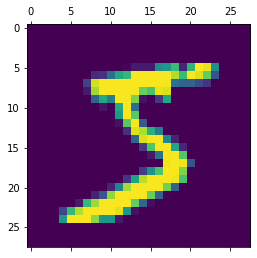

In [8]:
BATCH_SIZE = 256
dl = th.utils.data.DataLoader(ds_train, batch_size=BATCH_SIZE)
for x, in dl:
    break
plt.matshow(x[0].cpu().numpy().reshape(28,28))
x.shape

***
$\mathbf{\text{Gradient Tree Boosting Algorithm}}$<br>
***
$$f_{0}(x) = \textrm{arg min}_{\gamma} \sum \limits _{i=1} ^{N} L(y_{i}, \gamma)$$

1.&emsp;Initialize model with a constant value $$f_{0}(x) = \textrm{arg min}_{\gamma} \sum \limits _{i=1} ^{N} L(y_{i}, \gamma)$$
2.&emsp;For m = 1 to M:<br>
&emsp;&emsp;(a)&emsp;For $i = 1,2,...,N$ compute<br>
    $$r_{im} = - \displaystyle \Bigg[\frac{\partial L(y_{i}, f(x_{i}))}{\partial f(x_{i})}\Bigg]_{f=f_{m−1}}$$
&emsp;&emsp;(b)&emsp;Fit a regression tree to the targets $r_{im}$ giving terminal regions<br>
&emsp;&emsp;&emsp;&emsp;$R_{jm}, j = 1, 2, . . . , J_{m}.$<br><br>
&emsp;&emsp;(c)&emsp;For $j = 1, 2, . . . , J_{m}$ compute<br>
$$\gamma_{jm} = \underset{\gamma}{\textrm{arg min}} \sum \limits _{x_{i} \in R_{jm}} L(y_{i}, f_{m−1}(x_{i}) + \gamma)$$
<br>
&emsp;&emsp;(d)&emsp;Update $f_{m}(x) = f_{m−1}(x) + \sum _{j=1} ^{J_{m}} \gamma_{jm} I(x \in R_{jm})$<br><br>
3. Output $\hat{f}(x) = f_{M}(x)$
***

***
$\mathbf{\text{KL Reminder}}$<br>
***
$$KL = \textrm{arg min}_{\gamma} \sum \limits _{i=1} ^{N} L(y_{i}, \gamma)$$
$$KL(D_1,D_2) = \log (\frac{s_2}{s_1}) + \frac {1}{2} \frac {s_1^2 +(m_1 - m_2)^2} {s_2^2} - \frac{1}{2}$$


      if target is N(0,1) then s2 = 1 m2 = 0 then
       KL_Loss = 0 - log(s1) + 0.5 * (s1**2 + m1**2) - 0.5
       KL_loss = -0.5 * ( 2*log(s1) - s1**2 - m1**2 + 1)
       or when targeting the std instead of variance
       KL_loss = -0.5 * (log(s1) - s1 - m1**2 + 1)
         in this case z = rnd * s1 + m1
       or (targeting log_of_s1)
       KL_loss = -0.5 * (s1_ln - e**s1_ln - m1**2 + 1)
         in this case the z = rnd * e**(s1_ln/2) + m1

In [ ]:
class SimpleVAE(th.nn.Module):
    def __init__(self, inp_size, encoding=[512, 256], embedding_size=32):
        super().__init__()
        self.enc_layers = th.nn.ModuleList()
        prev_units = inp_size
        for units in encoding:
            self.enc_layers.append(th.nn.Linear(prev_units, units))
            self.enc_layers.append(th.nn.ReLU())
            prev_units = units
        
        # Here the stuff gets a bit more complicated than `self.embedding = th.nn.Linear(prev_units, embedding_size)`

        prev_units = embedding_size
        self.dec_layers = th.nn.ModuleList()
        for units in reversed(encoding):
            self.dec_layers.append(th.nn.Linear(prev_units, units))
            prev_units = units
            self.dec_layers.append(th.nn.ReLU())
        
        self.readout = th.nn.Linear(prev_units, inp_size)
        return
        
    def encoder(self, inputs):
        if len(inputs.shape) > 2: 
            # do NOT use this approach in real-life models.
            # instead use pre-processing reshaping (via tv pre-proc pipeline or manual)
            th_x = inputs.view(inputs.shape[0], -1)
        else:
            th_x = inputs
            
        for layer in self.enc_layers:
            th_x = layer(th_x)
        return self.embedding(th_x)
    
    def decoder(self, inputs):
        th_x = inputs
        for layer in self.dec_layers:
            th_x = layer(th_x)
        return self.readout(th_x)
    
    def forward(self, inputs):
        th_x = self.encoder(inputs)
        th_x = None # again the stuff gets a bit complicated
        th_x = self.decoder(th_x)
        
model = SimpleAutoEncoder(28*28).cuda()
model        
        